# Imports

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, matthews_corrcoef
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score as gms
from sklearn.neural_network import MLPClassifier

from aux import *

import pandas as pd
pd.options.display.max_columns = 100

seed = 1997

# Lectura de datos

In [2]:
# Leemos la base de datos
col_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points']
for i in range(1,5):
    col_names.append('Wilderness_Area_' + str(i))
for i in range(1,41):
    col_names.append('Soil_Type_' + str(i))
col_names.append('Cover_Type')

dataset = pd.read_csv('covtype.data', header=None, names=col_names)

In [3]:
dataset.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [4]:
X = dataset.drop('Cover_Type', axis=1)
y = dataset['Cover_Type']
y.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

# Train, test, val split

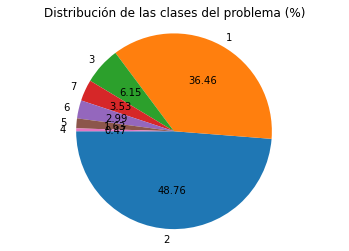

In [5]:
# Distribucion de las clases 
prop_class = y.value_counts(normalize=True)
pieLabels = ['2','1','3','7','6','5','4']
figureObject, axesObject = plt.subplots()
axesObject.pie(prop_class*100, labels=pieLabels, autopct='%1.2f', startangle=180)
axesObject.axis('equal')
plt.title("Distribución de las clases del problema (%)")
plt.show()

Separamos en train, vail y test.

Número de elementos de cada clase en `train`.

Undersampling

In [6]:
sizes = [6000, 6000, 1539, 118, 408, 748, 882]
X_train = []
y_train = []
X_rest = []
y_rest = []
for i in range(1,8):
    elems = X[y == i]
    X_train.append(elems.iloc[:sizes[i-1]])
    y_train.append(y[y==i].iloc[:sizes[i-1]])
    X_rest.append(elems.iloc[sizes[i-1]:])
    y_rest.append(y[y==i].iloc[sizes[i-1]:])
    
X_train = pd.concat(X_train)
y_train = pd.concat(y_train)
X_rest = pd.concat(X_rest)
y_rest = pd.concat(y_rest)
print(X_rest.shape)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=15000, stratify=y_rest, random_state=seed)

(565317, 54)


In [7]:
print("Tamaño del conjunto de entrenamiento: ", X_train.shape[0])
print("Tamaño del conjunto de validacion: ", X_val.shape[0])
print("Tamaño del conjunto de test: ", X_test.shape[0])

Tamaño del conjunto de entrenamiento:  15695
Tamaño del conjunto de validacion:  15000
Tamaño del conjunto de test:  550317


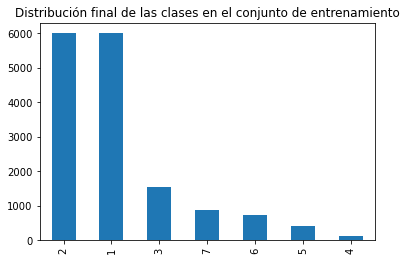

In [8]:
y_train.value_counts().plot(kind='bar', title='Distribución final de las clases en el conjunto de entrenamiento');

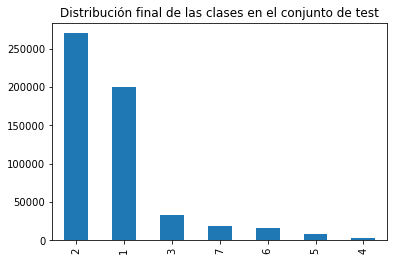

In [9]:
y_test.value_counts().plot(kind='bar', title='Distribución final de las clases en el conjunto de test');

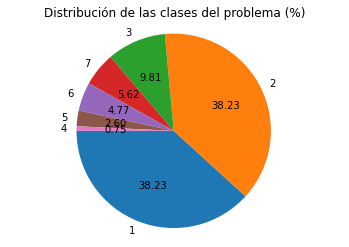

In [10]:
prop_class = y_train.value_counts(normalize=True)
pieLabels = ['1','2','3','7','6','5','4']
figureObject, axesObject = plt.subplots()
axesObject.pie(prop_class*100, labels=pieLabels, autopct='%1.2f', startangle=180)
axesObject.axis('equal')
plt.title("Distribución de las clases del problema (%)")
plt.show()

# Preprocesado

Definimos un `Pipeline` de preprocesado.

In [11]:
data_preprocess = Pipeline(
    [
        ("VT", VarianceThreshold()),
        ("Scaler", StandardScaler()),
        #("PCA", PCA(0.95)),
        #("Scaler2", StandardScaler()),
    ]
)

Preprocesamos el conjunto de entrenamiento y mostramos la matriz de correlación antes y después.

In [12]:
X_train_new = data_preprocess.fit_transform(X_train, y_train)
print(X_train.shape)
print(X_train_new.shape)
# se elimina el atributo Soil_Type_15 que tiene varianza 0

(15695, 54)
(15695, 52)


Matriz de correlación pre y post procesado (dígitos)


/usr/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


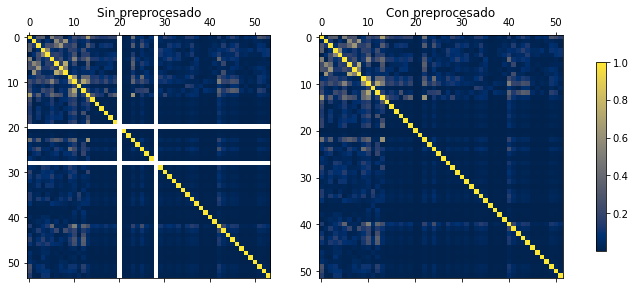

In [13]:
show_preprocess_correlation_matrix(X_train, X_train_new)

Preprocesamos validación y `test`.

In [14]:
X_train = X_train_new
X_val = data_preprocess.transform(X_val)
X_test = data_preprocess.transform(X_test)

# Modelos a considerar

Definimos un array con los modelos que vamos a considerar, se entrenarán y evaluarán en validación.

In [15]:
scorer = make_scorer(gms)
#scorer = make_scorer(f1_score, average = "micro")

In [16]:
reg_values_lin = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 100, 1000]
reg_values_svm = [250, 500, 1000, 1250]

In [17]:
linear_models = []
linear_models += [
    (
        "Perceptron: \u03B1={}".format(a),
        Perceptron(alpha=a, penalty="l2", class_weight='balanced', max_iter=1500, random_state=seed, n_jobs=-1),
    )
    for a in reg_values_lin
]
linear_models += [
    (
        "RidgeClassifier: \u03B1={}".format(a),
        RidgeClassifier(alpha=a, random_state=seed, class_weight='balanced', max_iter=1500),
    )
    for a in reg_values_lin
]
linear_models += [
    (
        "Logistic regresion: C={}".format(c),
        LogisticRegression(
            C=c, multi_class="ovr", penalty="l2", solver='saga', max_iter = 1500, class_weight='balanced', random_state=seed, n_jobs=-1
        ),
    )
    for c in reg_values_lin
]
#linear_models += [
#    (
#        "SGD Classifier: \u03B1={}".format(a),
#        SGDClassifier(alpha=a, class_weight='balanced', random_state=seed, n_jobs=-1)
#    )
#    for a in reg_values_lin
#]

In [18]:
svm_models = []
svm_models += [
    (
        "SVM (3-poly): C={}".format(c),
        SVC(C = c, kernel='poly', degree=3)
    )
    for c in reg_values_svm
]
svm_models += [
    (
        "SVM (5-poly): C={}".format(c),
        SVC(C = c, kernel='poly', degree=5)
    )
    for c in reg_values_svm
]
svm_models += [
    (
        "SVM (rbf): C={}".format(c),
        SVC(C = c, kernel='rbf')
    )
    for c in reg_values_svm
]

In [19]:
rf_models = []
rf_models += [
    (
        "Random Forest: {} estimators, 1000 samples".format(n),
        RandomForestClassifier(n_estimators=n, max_samples=1000, class_weight="balanced", 
                               n_jobs=-1, random_state=seed)
    )
    for n in [100,200,500]
]
rf_models += [
    (
        "Random Forest: {} estimators".format(n),
        RandomForestClassifier(n_estimators=n, class_weight="balanced", n_jobs=-1, 
                               random_state=seed)
    )
    for n in [100,200,500]
]

In [20]:
balanced_rf_models = [
    (
        "Balanced Random Forest: {} estimators, 1000 samples".format(n),
        BalancedRandomForestClassifier(n_estimators=n, sampling_strategy='not minority', 
                                        class_weight='balanced', random_state=seed, n_jobs=-1)

    )
    for n in [100,200,500]
]


In [21]:
MLP_models = [
    (
        "Multilayer perceptron: \u03B1={} ".format(a),
        MLPClassifier(alpha=a, random_state=seed)
    )
    for a in reg_values_lin
]


# Elección de modelo

Hacemos `K-fold cross-validation` sobre cada uno de los conjuntos de modelos: lineal, knn y SVM. Y seleccionamos el mejor de cada uno.

In [22]:
best_linear = kfold_models(linear_models, X_train, y_train, seed, 
                           scorer, stratified=False, verbose=True)

Los modelos que se van a considerar son: 
	 Perceptron: α=0.001
	 Perceptron: α=0.01
	 Perceptron: α=0.1
	 Perceptron: α=0.5
	 Perceptron: α=1
	 Perceptron: α=2
	 Perceptron: α=5
	 Perceptron: α=10
	 Perceptron: α=100
	 Perceptron: α=1000
	 RidgeClassifier: α=0.001
	 RidgeClassifier: α=0.01
	 RidgeClassifier: α=0.1
	 RidgeClassifier: α=0.5
	 RidgeClassifier: α=1
	 RidgeClassifier: α=2
	 RidgeClassifier: α=5
	 RidgeClassifier: α=10
	 RidgeClassifier: α=100
	 RidgeClassifier: α=1000
	 Logistic regresion: C=0.001
	 Logistic regresion: C=0.01
	 Logistic regresion: C=0.1
	 Logistic regresion: C=0.5
	 Logistic regresion: C=1
	 Logistic regresion: C=2
	 Logistic regresion: C=5
	 Logistic regresion: C=10
	 Logistic regresion: C=100
	 Logistic regresion: C=1000


--> Perceptron: α=0.001 <--
Score en K-fold: 0.572


--> Perceptron: α=0.01 <--
Score en K-fold: 0.346


--> Perceptron: α=0.1 <--
Score en K-fold: 0.000


--> Perceptron: α=0.5 <--
Score en K-fold: 0.000


--> Perceptron: α=1 <--
Scor

In [23]:
best_svm = kfold_models(svm_models, X_train, y_train, seed, scorer,
                        stratified=False, verbose=True)

Los modelos que se van a considerar son: 
	 SVM (3-poly): C=250
	 SVM (3-poly): C=500
	 SVM (3-poly): C=1000
	 SVM (3-poly): C=1250
	 SVM (5-poly): C=250
	 SVM (5-poly): C=500
	 SVM (5-poly): C=1000
	 SVM (5-poly): C=1250
	 SVM (rbf): C=250
	 SVM (rbf): C=500
	 SVM (rbf): C=1000
	 SVM (rbf): C=1250


--> SVM (3-poly): C=250 <--
Score en K-fold: 0.814


--> SVM (3-poly): C=500 <--
Score en K-fold: 0.816


--> SVM (3-poly): C=1000 <--
Score en K-fold: 0.813


--> SVM (3-poly): C=1250 <--
Score en K-fold: 0.819


--> SVM (5-poly): C=250 <--
Score en K-fold: 0.791


--> SVM (5-poly): C=500 <--
Score en K-fold: 0.796


--> SVM (5-poly): C=1000 <--
Score en K-fold: 0.798


--> SVM (5-poly): C=1250 <--
Score en K-fold: 0.799


--> SVM (rbf): C=250 <--
Score en K-fold: 0.835


--> SVM (rbf): C=500 <--
Score en K-fold: 0.834


--> SVM (rbf): C=1000 <--
Score en K-fold: 0.836


--> SVM (rbf): C=1250 <--
Score en K-fold: 0.834



Mejor modelo: SVC(C=1000)


In [24]:
best_rf = kfold_models(rf_models, X_train, y_train, seed, scorer,
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Random Forest: 100 estimators, 1000 samples
	 Random Forest: 200 estimators, 1000 samples
	 Random Forest: 500 estimators, 1000 samples
	 Random Forest: 100 estimators
	 Random Forest: 200 estimators
	 Random Forest: 500 estimators


--> Random Forest: 100 estimators, 1000 samples <--
Score en K-fold: 0.734


--> Random Forest: 200 estimators, 1000 samples <--
Score en K-fold: 0.729


--> Random Forest: 500 estimators, 1000 samples <--
Score en K-fold: 0.732


--> Random Forest: 100 estimators <--
Score en K-fold: 0.864


--> Random Forest: 200 estimators <--
Score en K-fold: 0.869


--> Random Forest: 500 estimators <--
Score en K-fold: 0.871



Mejor modelo: RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=1997)


In [25]:
best_balanced_rf = kfold_models(balanced_rf_models, X_train, y_train, seed, scorer,
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Balanced Random Forest: 100 estimators, 1000 samples
	 Balanced Random Forest: 200 estimators, 1000 samples
	 Balanced Random Forest: 500 estimators, 1000 samples


--> Balanced Random Forest: 100 estimators, 1000 samples <--
Score en K-fold: 0.836


--> Balanced Random Forest: 200 estimators, 1000 samples <--
Score en K-fold: 0.837


--> Balanced Random Forest: 500 estimators, 1000 samples <--
Score en K-fold: 0.839



Mejor modelo: BalancedRandomForestClassifier(class_weight='balanced', n_estimators=500,
                               n_jobs=-1, random_state=1997,
                               sampling_strategy='not minority')


In [26]:
best_MLP = kfold_models(MLP_models, X_train, y_train, seed, scorer,
                        stratified=True, verbose=True)

Los modelos que se van a considerar son: 
	 Multilayer perceptron: α=0.001 
	 Multilayer perceptron: α=0.01 
	 Multilayer perceptron: α=0.1 
	 Multilayer perceptron: α=0.5 
	 Multilayer perceptron: α=1 
	 Multilayer perceptron: α=2 
	 Multilayer perceptron: α=5 
	 Multilayer perceptron: α=10 
	 Multilayer perceptron: α=100 
	 Multilayer perceptron: α=1000 


--> Multilayer perceptron: α=0.001  <--
Score en K-fold: 0.819


--> Multilayer perceptron: α=0.01  <--
Score en K-fold: 0.819


--> Multilayer perceptron: α=0.1  <--
Score en K-fold: 0.807


--> Multilayer perceptron: α=0.5  <--
Score en K-fold: 0.742


--> Multilayer perceptron: α=1  <--
Score en K-fold: 0.674


--> Multilayer perceptron: α=2  <--
Score en K-fold: 0.627


--> Multilayer perceptron: α=5  <--
Score en K-fold: 0.500


--> Multilayer perceptron: α=10  <--
Score en K-fold: 0.000


--> Multilayer perceptron: α=100  <--
Score en K-fold: 0.000


--> Multilayer perceptron: α=1000  <--
Score en K-fold: 0.000



Mejor model

Entrenamos y evaluamos cada modelo en el conjunto de validación, quedandonos con el mejor de ellos en `best_model`.

In [27]:
best_model = 0
best_model_score = 0

models = [best_linear, best_svm, best_rf, best_balanced_rf, best_MLP]

for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    val_score =  gms(y_val, y_pred)
    print("Validation Score: ", val_score)
    if best_model_score < val_score:
        best_model_score = val_score
        best_model = model

LogisticRegression(C=10, class_weight='balanced', max_iter=1500,
                   multi_class='ovr', n_jobs=-1, random_state=1997,
                   solver='saga')


/home/ludvins/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Validation Score:  0.4437744422444646
SVC(C=1000)
Validation Score:  0.42320903136262183
RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=-1,
                       random_state=1997)
Validation Score:  0.3791098346271748
BalancedRandomForestClassifier(class_weight='balanced', n_estimators=500,
                               n_jobs=-1, random_state=1997,
                               sampling_strategy='not minority')
Validation Score:  0.4089157364816981


El mejor modelo ha resultado:

In [28]:
print(best_model)

LogisticRegression(C=10, class_weight='balanced', max_iter=1500,
                   multi_class='ovr', n_jobs=-1, random_state=1997,
                   solver='saga')


# Predicción

Predecimos los valores de `test` con dicho modelo.

In [29]:
y_pred = best_model.predict(X_test)
print("Score obtenido: {:.2f}".format(gms(y_test, y_pred)))

F1-score obtenido: 0.45


Mostramos la curva de aprendizaje obtenida por el modelo de la siguiente forma, empezamos tomando el $10\%$ del conjunto de `train` y hacemos `cross-validation` con dicho conjunto, repetimos el proceso aumentando el porcentage del conjunto utilizado hasta llegar al $100\%$.

/home/ludvins/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ludvins/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ludvins/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1372, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ludvins/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be 

<module 'matplotlib.pyplot' from '/usr/lib/python3.8/site-packages/matplotlib/pyplot.py'>

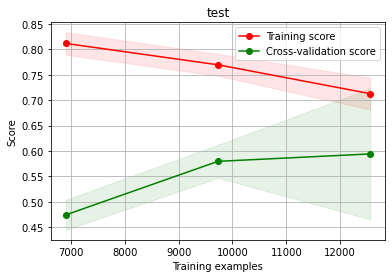

In [30]:
plot_learning_curve(best_model, "test", X_train, y_train)

Mostramos la matriz de confusión de los datos

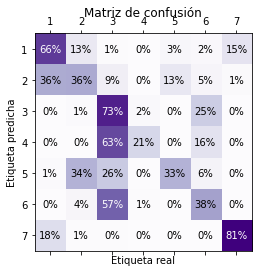

In [31]:
"""Muestra matriz de confusión de la base de datos de dígitos."""
show_confusion_matrix(y_test, y_pred, 7)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.66      0.61    200379
           2       0.77      0.36      0.49    269943
           3       0.38      0.73      0.50     33307
           4       0.43      0.21      0.29      2559
           5       0.07      0.33      0.11      8844
           6       0.19      0.38      0.25     16178
           7       0.31      0.81      0.45     19107

    accuracy                           0.51    550317
   macro avg       0.39      0.50      0.39    550317
weighted avg       0.63      0.51      0.52    550317



In [33]:
y_test.value_counts()

2    269943
1    200379
3     33307
7     19107
6     16178
5      8844
4      2559
Name: Cover_Type, dtype: int64